In [1]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

from qtpyt.basis import Basis


In [ ]:
atoms = read("../structures/unrelaxed/sorted/scatt.xyz")

z_threshold = 30
x_coords = atoms.positions[:, 0]
z_coords = atoms.positions[:, 2]

x_min, x_max = np.min(x_coords), np.max(x_coords)
x_threshold = (x_max + x_min) * 0.5

symbols = atoms.get_chemical_symbols()
total_atoms = len(atoms)

num_spherical_harmonics = {"C": 9, "H": 4}

left_lead_indices = []
right_lead_indices = []
bridge_indices = []

for i, (x, z) in enumerate(zip(x_coords, z_coords)):
    if z < z_threshold:
        if x < x_threshold:
            left_lead_indices.append(i)
        else:
            right_lead_indices.append(i)
    else:
        bridge_indices.append(i)

left_lead_indices = np.array(left_lead_indices)
right_lead_indices = np.array(right_lead_indices)
bridge_indices = np.array(bridge_indices)

print("Total atoms:", total_atoms)
print("Left lead atoms:", len(left_lead_indices))
print("Right lead atoms:", len(right_lead_indices))
print("Bridge atoms:", len(bridge_indices))


total_sph_left_lead = sum(num_spherical_harmonics[symbols[i]] for i in left_lead_indices)
total_sph_bridge = sum(num_spherical_harmonics[symbols[i]] for i in bridge_indices)
total_sph_right_lead = sum(num_spherical_harmonics[symbols[i]] for i in right_lead_indices)

regions = [
    0,
    total_sph_left_lead,
    total_sph_left_lead + total_sph_bridge,
    total_sph_left_lead + total_sph_bridge + total_sph_right_lead
]

print("Number of orbitals in left lead =", regions[1] - regions[0])
print("Number of orbitals in bridge =", regions[2] - regions[1])
print("Number of orbitals in right lead =", regions[3] - regions[2])

# np.save("../unrelaxed/output/lowdin/regions.npy", regions)


Total atoms: 1216
Left lead atoms: 432
Right lead atoms: 432
Bridge atoms: 352
Number of orbitals in left lead = 3888
Number of orbitals in bridge = 2848
Number of orbitals in right lead = 3888


In [3]:
basis = {'C': 9, 'H': 4}

lead_atoms = read('../structures/unrelaxed/sorted/leads_1rep.xyz')
leads_basis = Basis.from_dictionary(lead_atoms, basis)

device_atoms = read('../structures/unrelaxed/sorted/scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis)

nodes = [0, leads_basis.nao, device_basis.nao - leads_basis.nao, device_basis.nao]

np.save("../unrelaxed/output/lowdin/nodes.npy", nodes)

/tmp/ipykernel_1289596/1973003139.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 256)


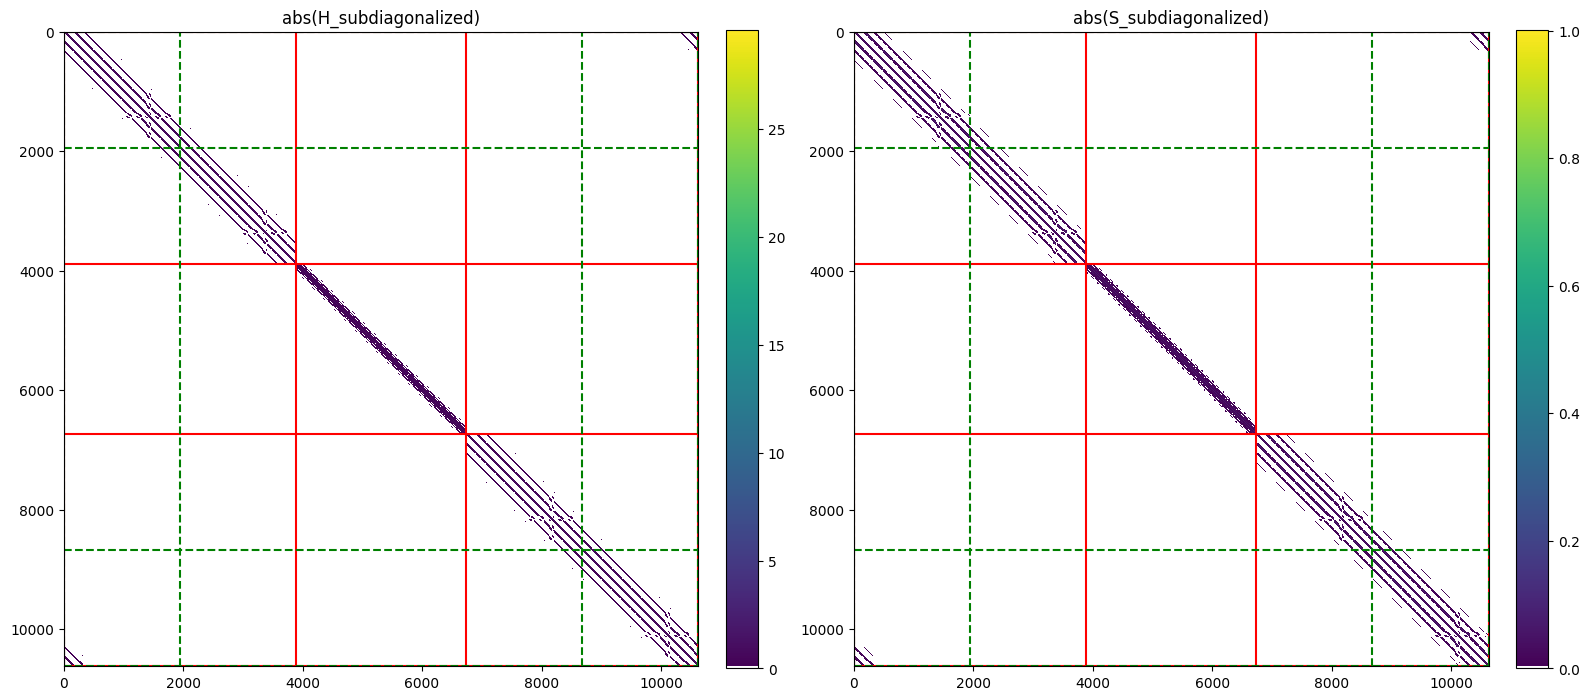

In [6]:
"""
Visualizes the absolute values of the subdiagonalized Hamiltonian matrix with block structure boundaries.

This script performs the following steps:

Loads the region partitioning indices and the subdiagonalized Hamiltonian from the specified data folder.
   - `regions.npy` contains the block boundary indices. Example: [0, 290, 544, 816]
   - `hs_los_lowdin.npy` contains the lowdin-orthogonalized Hamiltonian data.

Plots the absolute values of `H_subdiagonalized` using `imshow` with the custom colormap.

Overlays red horizontal and vertical lines at each region boundary to highlight the block structure of the matrix.


This visualization helps identify the block structure of the Hamiltonian after subdiagonalization, making it easier
to inspect couplings between different subsystems or partitions.

"""

data_folder = "../unrelaxed/output/lowdin"
regions = np.load(f"{data_folder}/regions.npy")
H_subdiagonalized, S_subdiagonalized = np.load(f"{data_folder}/hs_los.npy")
H_subdiagonalized = H_subdiagonalized[0]
S_subdiagonalized = S_subdiagonalized[0]
cmap = cm.get_cmap('viridis', 256)
new_colors = cmap(np.linspace(0, 1, 256))
new_colors[0] = [1, 1, 1, 1]
new_cmap = ListedColormap(new_colors)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))


im0 = axes[0].imshow(np.abs(H_subdiagonalized), cmap=new_cmap)
axes[0].set_title("abs(H_subdiagonalized)")
for region in regions:
    axes[0].axhline(region - 0.5, color='red', linewidth=1.5)
    axes[0].axvline(region - 0.5, color='red', linewidth=1.5)

for node in nodes:
    axes[0].axhline(node - 0.5, color='green', linewidth=1.5, linestyle='--')
    axes[0].axvline(node - 0.5, color='green', linewidth=1.5, linestyle='--')

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


im1 = axes[1].imshow(np.abs(S_subdiagonalized), cmap=new_cmap)
axes[1].set_title("abs(S_subdiagonalized)")
for region in regions:
    axes[1].axhline(region - 0.5, color='red', linewidth=1.5)
    axes[1].axvline(region - 0.5, color='red', linewidth=1.5)

for node in nodes:
    axes[1].axhline(node - 0.5, color='green', linewidth=1.5, linestyle='--')
    axes[1].axvline(node - 0.5, color='green', linewidth=1.5, linestyle='--')

fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
